# Telecom Churn

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

### Objective
The business objective is to predict the churn in the last month using the data from the first three months. We will be checking usage based churn. Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

### Import Necessary Libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, seaborn as sns, sklearn

#Options to display rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_info_columns', 500)

#Hide Warnings
import warnings
warnings.filterwarnings('ignore')

#Statsmodels API
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Sklearn libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, plot_roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA

#To handle imbalance
from imblearn.over_sampling import SMOTE

import xgboost as xgb

## 1. Data Understanding

In [2]:
#Read data from csv
df = pd.read_csv('telecom_churn_data.csv')

#Print Top 5 rows
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,...,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,252,252,252,0,6/21/2014,7/16/2014,8/8/2014,NaN,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.3

In [3]:
#Print data frame info to inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mobile_number             99999 non-null  int64  
 1   circle_id                 99999 non-null  int64  
 2   loc_og_t2o_mou            98981 non-null  float64
 3   std_og_t2o_mou            98981 non-null  float64
 4   loc_ic_t2o_mou            98981 non-null  float64
 5   last_date_of_month_6      99999 non-null  object 
 6   last_date_of_month_7      99398 non-null  object 
 7   last_date_of_month_8      98899 non-null  object 
 8   last_date_of_month_9      98340 non-null  object 
 9   arpu_6                    99999 non-null  float64
 10  arpu_7                    99999 non-null  float64
 11  arpu_8                    99999 non-null  float64
 12  arpu_9                    99999 non-null  float64
 13  onnet_mou_6               96062 non-null  float64
 14  onnet

#### There are 99999 rows with 226 columns. All columns are numerical except for 4 columns which are dates. 

In [4]:
#Print stats for numerical variables
df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,...,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,9

## 2. Data Cleaning

In [5]:
# Set Mobile number as index and drop it
df = df.set_index('mobile_number', drop=True)

In [6]:
#Function to Print null percentages with percentage greater than threshold.
#If threshold is not specified, pritns all null percentages
def get_null_perc(df, thresh = None):
    null_perc = round(100 * df.isnull().sum()/len(df), 2)
    if thresh == None :
        return null_perc
    else :
        return null_perc[null_perc > thresh]

In [7]:
#List of columns having more than 40% nulls
drop_col = get_null_perc(df,40)

#Print the columns to be dropped
print(drop_col.index)

print('Number of columns to drop:', len(drop_col))

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6',
       'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6', 'arpu_3g_7',
       'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
       'arpu_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
       'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9'],
      dtype='object')
Number of columns to drop: 40


In [8]:
#Drop Columns having more than 40% nulls 
df.drop(columns=drop_col.index, inplace=True)

#Check the shape after dropping
print(df.shape)

(99999, 185)


### 2.1 Skewed Columns

In [9]:
cols_skew = df.skew() 
#Columns having skewness more than 100
print(cols_skew[cols_skew > 100].index)

Index(['roam_ic_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'isd_og_mou_9', 'og_others_6', 'og_others_7', 'og_others_8',
       'og_others_9'],
      dtype='object')


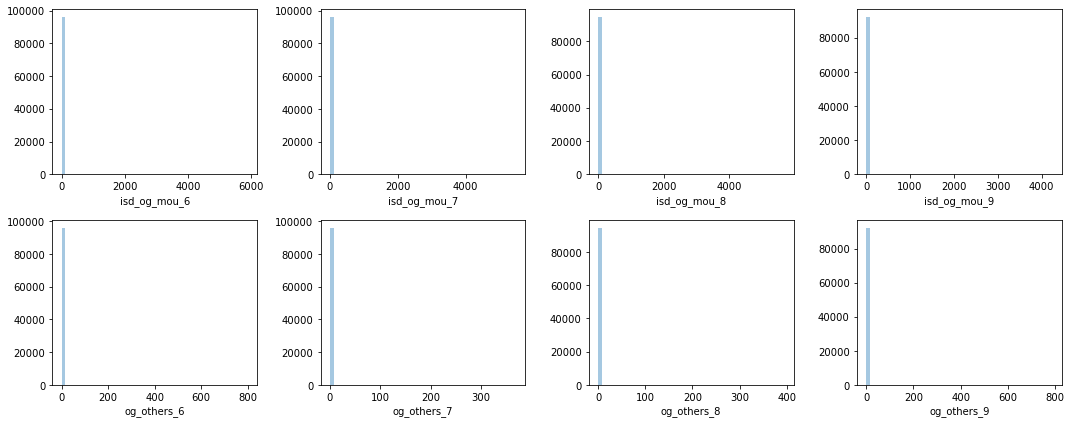

In [10]:
#Drop group of columns having skewness > 100
drop_col = ['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'isd_og_mou_9', 'og_others_6', 'og_others_7', 'og_others_8',
       'og_others_9']

plt.figure(figsize=(15,6))

#Check the skewness using distribution before dropping
for i, col in enumerate(drop_col):
    plt.subplot(2,4,i+1)
    sns.distplot(df[col], kde=False)
    
plt.tight_layout()

In [11]:
#Drop highly skewed columns
df.drop(columns=drop_col, inplace=True)

#Check the shape after dropping
print(df.shape)

(99999, 177)


### 2.2 Columns with only one value

In [12]:
#Number of unique values in each column
unique_val_counts = df.nunique()

#Print the columns having only one value
unique_val_counts[unique_val_counts==1]

circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
last_date_of_month_9    1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_og_t2c_mou_9        1
std_ic_t2o_mou_6        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_8        1
std_ic_t2o_mou_9        1
dtype: int64

In [13]:
#Drop columns which have only one value, they are not useful in modeling
drop_col = unique_val_counts[unique_val_counts==1].index
df.drop(columns = drop_col,inplace=True)

#Check the shape after dropping
print(df.shape)

(99999, 161)


In [14]:
unique_val_counts = df.nunique()
#Print number of unique values in each column to identify categorical columns. 
#To save space, print only the columns with less than 50 unique values (Other columns would be continuous columns)
unique_val_counts[unique_val_counts<50].sort_values()

monthly_2g_6            5
monthly_2g_9            5
monthly_2g_7            6
monthly_2g_8            6
monthly_3g_9           11
monthly_3g_8           12
monthly_3g_6           12
monthly_3g_7           15
sachet_3g_6            25
sachet_3g_9            27
sachet_3g_7            27
sachet_3g_8            29
date_of_last_rech_6    30
date_of_last_rech_9    30
date_of_last_rech_8    31
date_of_last_rech_7    31
sachet_2g_6            32
sachet_2g_9            32
sachet_2g_8            34
sachet_2g_7            35
dtype: int64

#### Majority of the columns are continuous numeric type. Very few columns like monthly_2g_6 are discrete numerical varibales.

### 2.3 Handle Missing Values

In [15]:
#Check null percentages for numeric columns
num_cols = df.select_dtypes('number').columns
print('Number of Numeric columns with nulls:', len(get_null_perc(df[num_cols], 0)))

#Print Few of them
get_null_perc(df[num_cols], 0).head()

Number of Numeric columns with nulls: 100


onnet_mou_6     3.94
onnet_mou_7     3.86
onnet_mou_8     5.38
onnet_mou_9     7.75
offnet_mou_6    3.94
dtype: float64

In [16]:
#List of numeric variables
num_cols = df.select_dtypes('number').columns

#Numeric variables with null values
cols = get_null_perc(df[num_cols], 0).index.values

#### Replace nulls in numeric variables with zero

In [17]:
# Replace nulls with zrto 
df[cols] = df[cols].fillna(0)

In [18]:
#Check for null percentages after handling it for numeric vartiables
get_null_perc(df,0)

date_of_last_rech_6    1.61
date_of_last_rech_7    1.77
date_of_last_rech_8    3.62
date_of_last_rech_9    4.76
dtype: float64

#### Now, only date columns have nulls

## 3 Data Preparation
### 3.1 High Value Customers

Derive High Value Customers using Average recharge made by each customer in June and July

In [19]:
#Calculate average recharge in June and July
df['avg_rech_6_7'] = (df.total_rech_amt_6+df.total_rech_amt_7)/2

#Check few rows after calculation
df[['total_rech_amt_6','total_rech_amt_7','avg_rech_6_7']].head()

,total_rech_amt_6,total_rech_amt_7,avg_rech_6_7
mobile_number,,,
7000842753,362,252,307.0
7001865778,74,384,229.0
7001625959,168,315,241.5
7001204172,230,310,270.0
7000142493,196,350,273.0


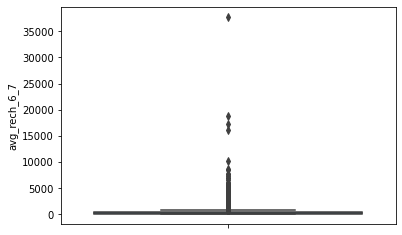

In [20]:
#Check the distribution of average recharge
sns.boxplot(y=df['avg_rech_6_7'])
plt.show()

#### Average Recharge for months 6 and 7 is skewed to right with high density on the lower side

In [21]:
#Calculate 70th percentile value of average recharge
avg_rech_70 = df.avg_rech_6_7.quantile(.7)
print('70th percentile value of average recharge:', avg_rech_70)

#Define High Value customers as those who generate more revenue, i.e average recharge > .7 quantile value 
df_hvc = df[df.avg_rech_6_7 >= avg_rech_70]

70th percentile value of average recharge: 368.5


### 3.2 Derive Churn

Customers who haven't received any call and made any outgoing calls with no data usage are identified as churned customers

In [22]:
#Create a new column for Churn
df_hvc['Churn'] = 0

# Set customers with no recharges and no data usage as Churned customers from month 9 as Churn customers
df_hvc.loc[(df_hvc.total_og_mou_9 == 0) & (df_hvc.total_ic_mou_9 == 0) & 
           (df_hvc.vol_2g_mb_9 == 0) & (df_hvc.vol_3g_mb_9 == 0), 'Churn'] = 1

In [23]:
#Check Churn count
df_hvc.Churn.value_counts()

0    27418
1     2593
Name: Churn, dtype: int64

### 3.3 Drop September columns 
After derving churn, we don't need 9th month columns. Drop them 

In [24]:
mon9_cols = ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 
 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'spl_og_mou_9',
 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9',
 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
 'date_of_last_rech_9', 'last_day_rch_amt_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9',
 'monthly_3g_9', 'sachet_3g_9', 'sep_vbc_3g']

In [25]:
#Drop September columns
df_hvc.drop(columns=mon9_cols, inplace=True)

#Check shape after dropping columns
df_hvc.shape

(30011, 123)

# 4. Exploratory Data Analysis

## 4.1 Univariate Analysis

### Data Imbalance

In [26]:
df_hvc.Churn.value_counts(normalize=1)

0    0.913598
1    0.086402
Name: Churn, dtype: float64

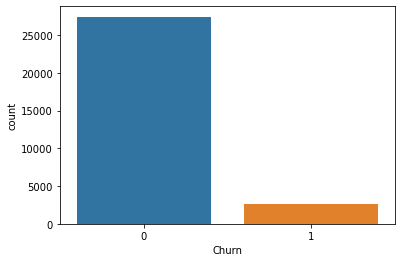

In [27]:
#Check Imbalnce in Churn varibale using count plot
sns.countplot(df_hvc.Churn)
plt.show()

#### Observations:
1. There are about 9% churned customers. This is high data Imbalance

### Continuous Numeric Variable distributions

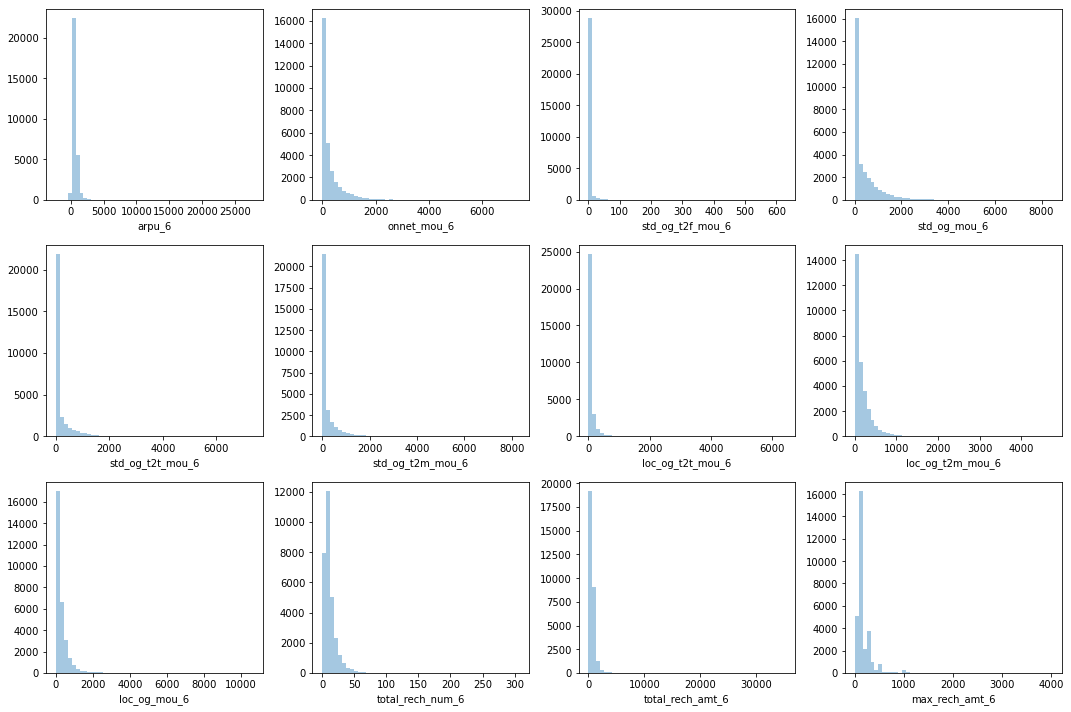

In [28]:
#Chech Distribution of numeric variables for June
cols = ['arpu_6','onnet_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 
        'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_mou_6' ,
        'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6']

plt.figure(figsize=(15,10))

#Drawing distribution of the identified continuous variables only to reduce number of charts
for i, col in enumerate(cols):
    plt.subplot(3,4,i+1)
    sns.distplot( df_hvc[col].dropna(),kde=False,hist=True )
    
plt.tight_layout()

#### Observations:
1. Average Revenue Per User in the month of june is almost normally distributed
2. Onnet calls are skewed to the right in June. Most of the users do not make ONNET voice calls.
3. Almost all users do not make STD calls to fixed line
4. STD and Local Outgoing calls to other operator mobiles are skewed to right. Mostof the customers use it moderately.
5. Number of recharges are close to normal distribution

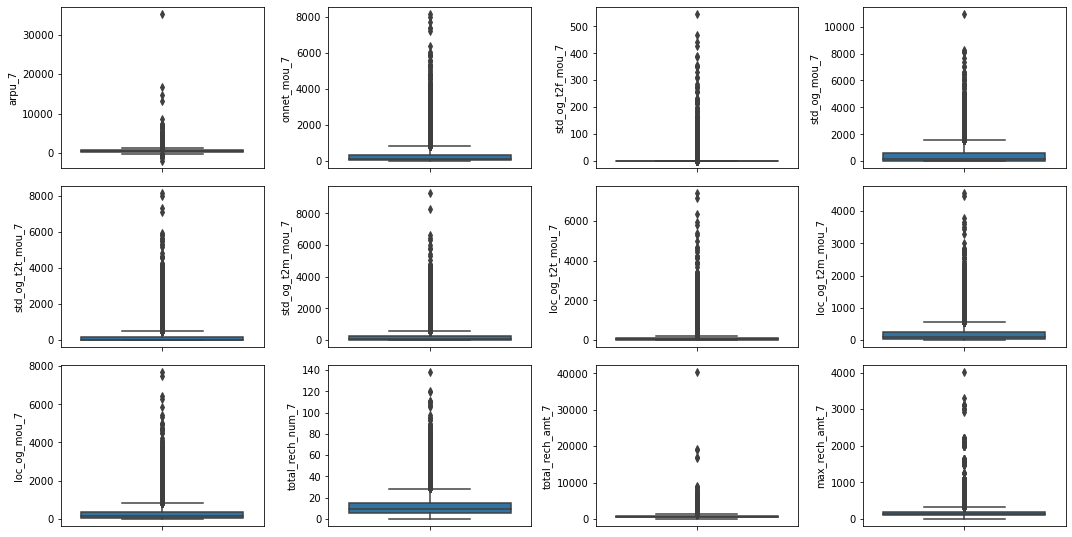

In [29]:
#Draw box plots for few numeric variables of July month 
cols = ['arpu_7','onnet_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 
        'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_mou_7' ,
        'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7']

plt.figure(figsize=(15,10))

#Drawing distribution of the identified continuous variables only to reduce number of charts
for i, col in enumerate(cols):
    plt.subplot(4,4,i+1)
    g = sns.boxplot( y=df_hvc[col].dropna() )
    
plt.tight_layout()

#### Observations:
1. Average Revenue Per User is still low for High Value Customers. Most of the users generate a revenue below 1000. This distribution is skewed to the right as few customers produce high revenue
2. 75% of customer make less than 400 local Out going Calls. There are few customers who makes very high number of local calls. This is true with other type of calls as well, few customers make high volume calls, they are outliers in the data set.
3. Total recharge amount for 75% of customer is under 900.

In [30]:
#As there are no categorical variables, use date columns to check churn rate by dates
df_hvc.select_dtypes('object').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

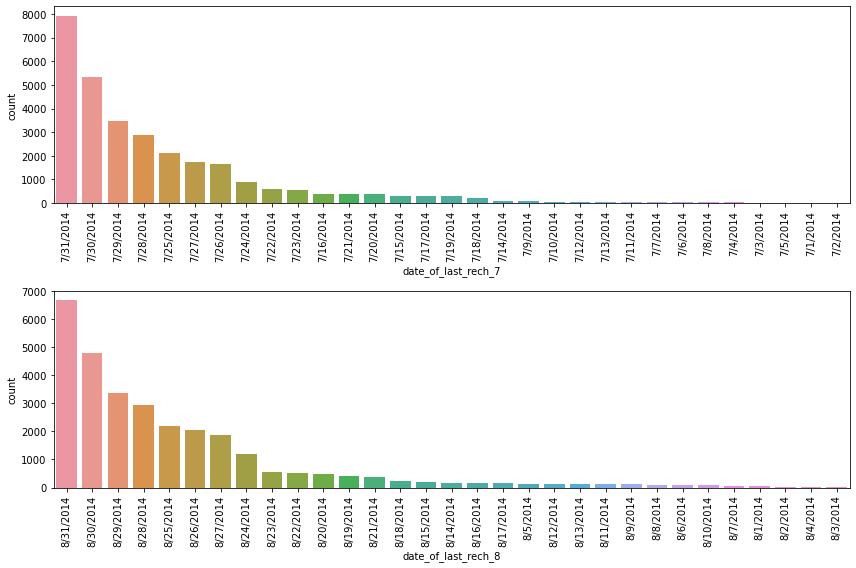

In [31]:
#Pick couple of date columns for analysis
cols = ['date_of_last_rech_7', 'date_of_last_rech_8']

plt.figure(figsize=(12,8))

#Draw count plots for these columns to check their churn rate
for i, col in enumerate(cols):
    plt.subplot(2,1,i+1)
    sns.countplot(df_hvc[col], order=df_hvc[col].value_counts().index)
    plt.xticks(rotation=90)
    
plt.tight_layout()

#### Observations:
1. Majority customers recharge towards the end of the month. Recharges in the first 3 weeks are low compared to last week

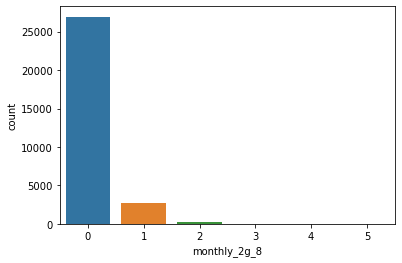

In [32]:
#Draw Count plot For Monthly 2G services taken by customers in September
sns.countplot(df_hvc['monthly_2g_8'], order=df_hvc['monthly_2g_8'].value_counts().index)
plt.show()

#### Majority customers do not use services with one month validity. Few customers use one service.

## 4.2 Bivariate Analysis

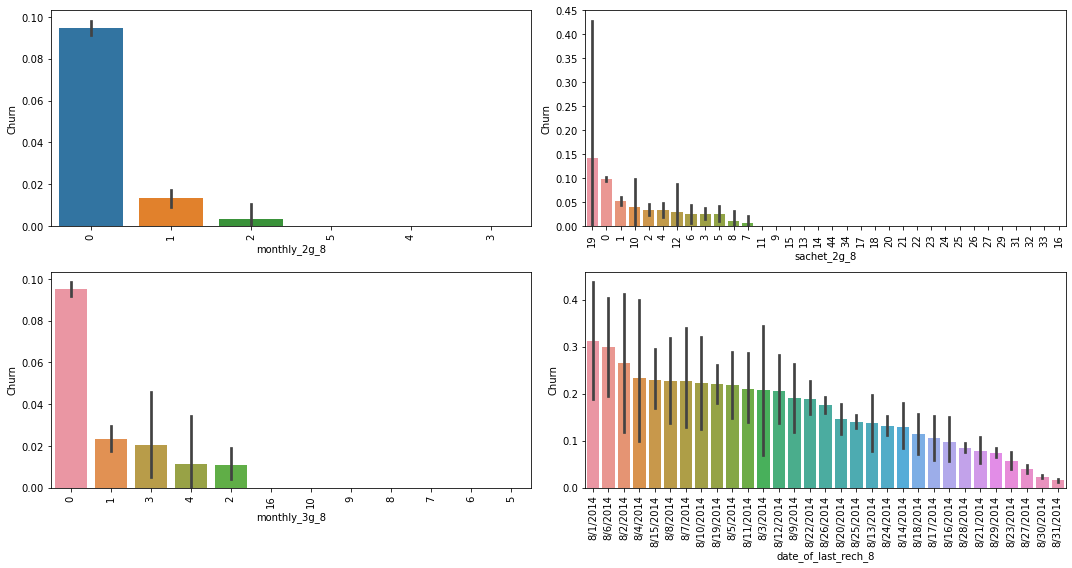

In [33]:
#Pick few categorical columns for analysis
cols = ['monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'date_of_last_rech_8']
plt.figure(figsize=(15, 8))

#Check the Churn Rate for couple of categorical columns to identify any trends
for i, col in enumerate(cols):
    plt.subplot(2,2,i+1)
    #Draw bars sorted by Churn rate
    sns.barplot(x=col,y='Churn', data=df_hvc, 
                order = df_hvc.groupby(col).mean()['Churn'].sort_values(ascending=False).index)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#### Observations:
1. Customers who have not used any monthly validity 2g and 3g service more likely to churn.
2. There is no clear pattern with customers using smaller validity 2g service. They churn randomly.
3. Customers whose last recharge falls in first half of the month are more likely to churn

### Pair Plots

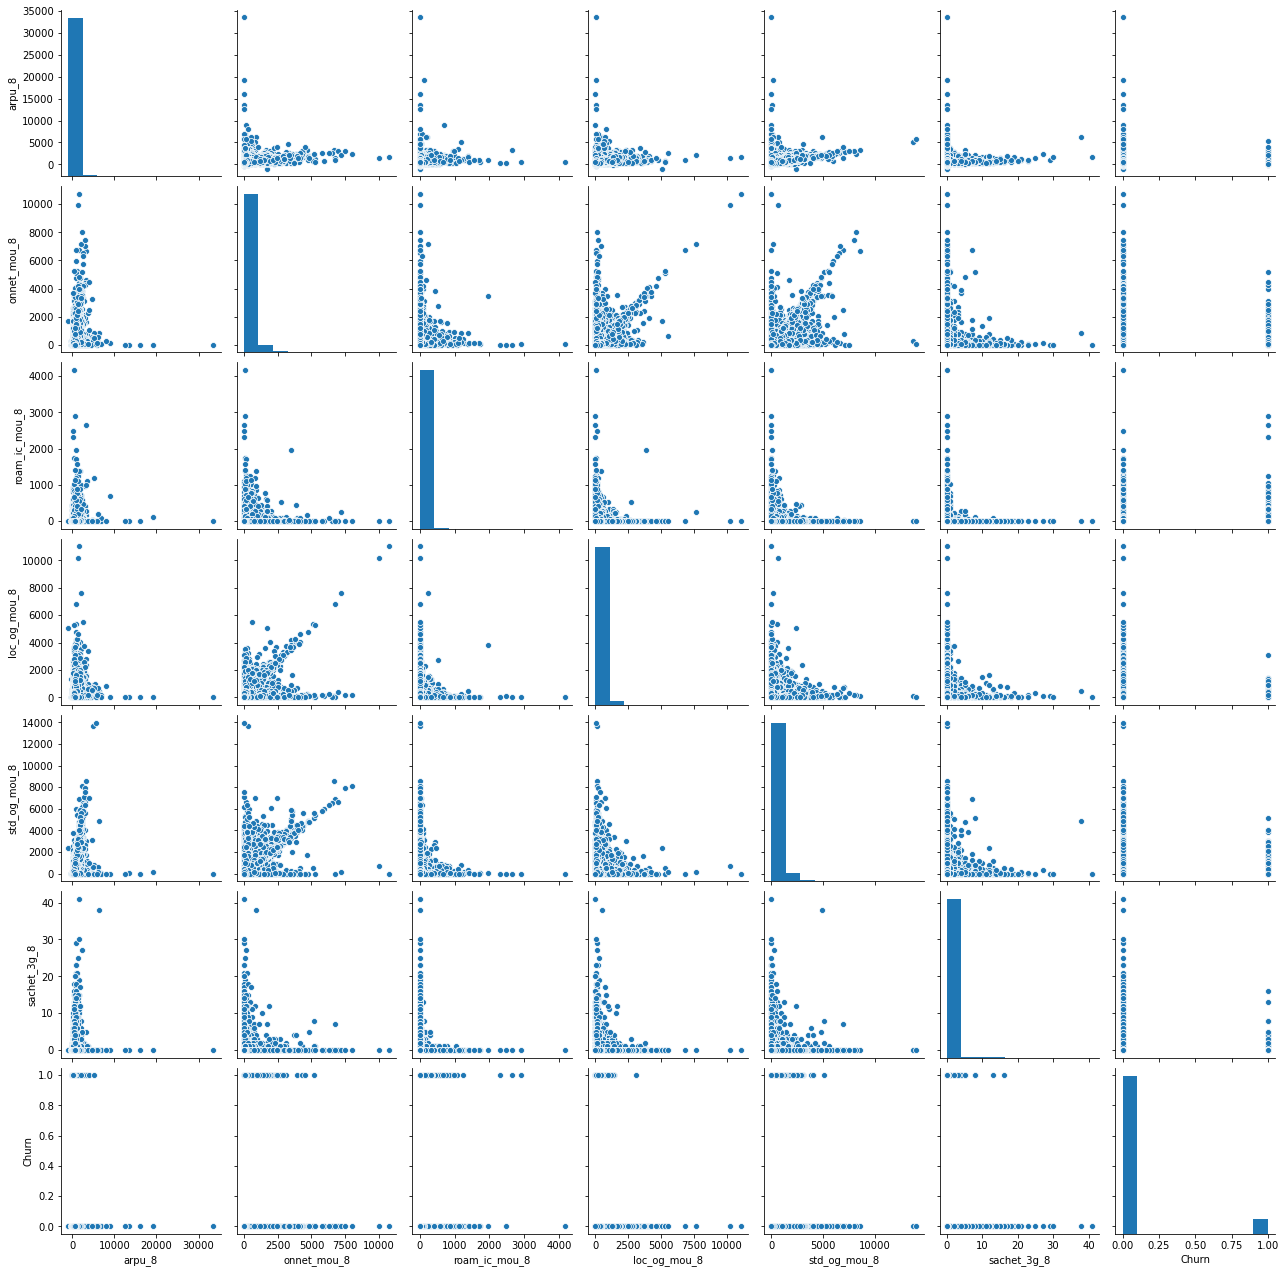

In [34]:
#Pick few columns to draw scatter plots
cols = ['arpu_8','onnet_mou_8','roam_ic_mou_8', 'loc_og_mou_8' , 
        'std_og_mou_8', 'sachet_3g_8','Churn']

sns.pairplot(df_hvc[cols])
plt.show()

#### Observations:
1. ONNET calls are correlated with STD and Local Outgoing calls
2. Smaller Validity service usage is negatively correlated with Revenue and all usage types.
3. Customer who generate more revenue are less likely to Churn

### Correlations

In [35]:
cols = ['arpu_8','onnet_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
        'loc_og_t2c_mou_8', 'loc_og_mou_8' , 'std_og_t2m_mou_8',
        'std_og_mou_8', 'aon', 'avg_rech_6_7', 'total_rech_amt_8', 'Churn']

corr = df_hvc[cols].corr()

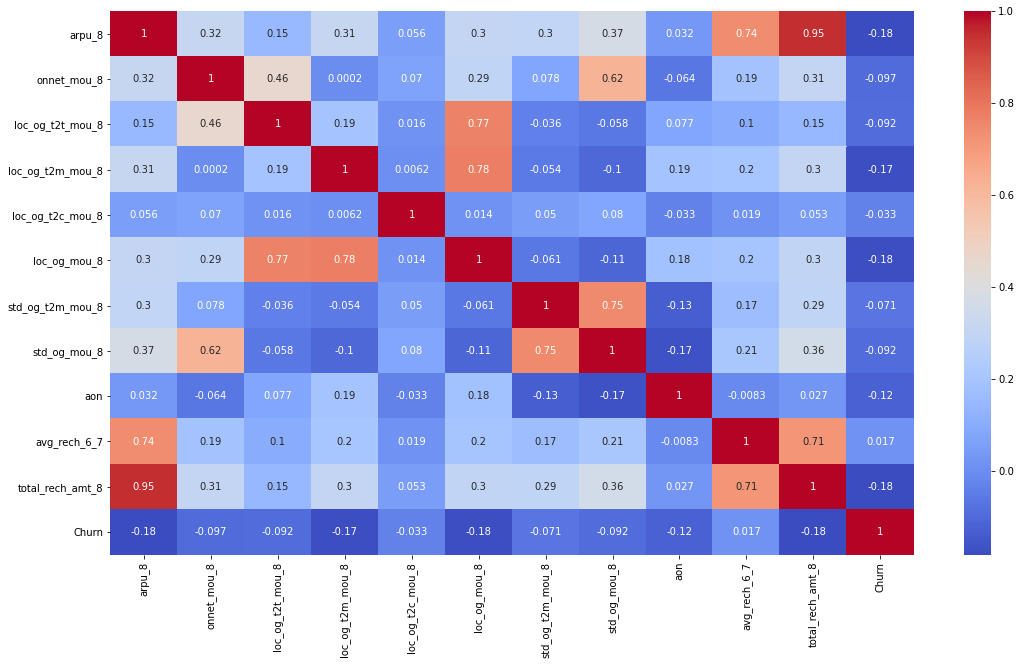

In [36]:
plt.figure(figsize=(18, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

#### Observations:
1. ONNET calls are highly correlated with STD Out Going calls
2. Average Revenue per User is highly correlated with total recharge for september and moderately correlated withaverage recharge amount for June and July. This is expected.
3. Surprisingly, Churn is negatively correlated with with most of the variables along with Average Revenue and Total Recharge. This correlation is very low but it is negative.

# 5. Feature Engineering

In [37]:
#Calculate sum of individual STG Outgoing component to verify it is same as aggregate value
df_hvc['std_agg_og'] = df_hvc.std_og_t2t_mou_8 + df_hvc.std_og_t2m_mou_8 + df_hvc.std_og_t2f_mou_8 
df_hvc[['std_agg_og','std_og_mou_8']].head()

,std_agg_og,std_og_mou_8
mobile_number,,
7000701601,77.83,77.84
7001524846,98.27,98.28
7002191713,655.17,655.18
7000875565,21.52,21.53
7000187447,0.00,0.00


#### Total calls made using T2M, T2T and T2F is equal to std_og_mou_8, hence we can drop this column. This applies to STD and Local incoming and outgoing calls. Let us drop these as the information is anyway captured by individual components

In [38]:
#Columns to be dropped
drop_col = ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
            'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8',
            'std_agg_og']
df_hvc.drop(columns=drop_col, inplace=True)

#Check the shape after dropping columns
df_hvc.shape

(30011, 111)

### 5.1 Derive Variables - Average of June and July

In [39]:
col_suffixes = ['arpu_', 'onnet_mou_', 'offnet_mou_', 'roam_ic_mou_', 'roam_og_mou_', 'loc_og_t2t_mou_', 'loc_og_t2m_mou_', 'loc_og_t2f_mou_', 'loc_og_t2c_mou_', 'std_og_t2t_mou_', 'std_og_t2m_mou_', 'std_og_t2f_mou_', 'spl_og_mou_', 'total_og_mou_', 'loc_ic_t2t_mou_', 'loc_ic_t2m_mou_', 'loc_ic_t2f_mou_', 'std_ic_t2t_mou_', 'std_ic_t2m_mou_', 'std_ic_t2f_mou_', 'total_ic_mou_', 'spl_ic_mou_', 'isd_ic_mou_', 'ic_others_', 'total_rech_num_', 'total_rech_amt_', 'max_rech_amt_','vol_2g_mb_', 'vol_3g_mb_', 'monthly_2g_', 'sachet_2g_', 'monthly_3g_', 'sachet_3g_']

for col_suffix in col_suffixes:
    #Derive a new variables
    df_hvc[col_suffix+'6_7'] = (df_hvc[col_suffix +'6'] + df_hvc[col_suffix +'7'])/2
    
    #Drop variables for individual months
    df_hvc.drop(columns=[col_suffix +'6',col_suffix +'7'], inplace=True)

In [40]:
#Check shape of dataframe after dropping
df_hvc.shape

(30011, 78)

### 5.2 Derive Variable - Average Amount per Recharge

In [41]:
#Calculate average recharge for all 3 months
df_hvc['avg_rech_6_7']= df_hvc.total_rech_amt_6_7/df_hvc.total_rech_num_6_7
df_hvc['avg_rech_8']= df_hvc.total_rech_amt_8/df_hvc.total_rech_num_8

#Replace NaNs with zero, these are the ones who did not make any recharge
df_hvc[['avg_rech_6_7', 'avg_rech_8']] = df_hvc[['avg_rech_6_7', 'avg_rech_8']].fillna(0)

### 5.3 Derive Variable - Last Recharge by Fortnight 

In [42]:
#Function to extract fortnigh from date
def extract_fortnight(date):
        day = int(date.split('/')[1])
        return 'First' if day <= 15 else 'Second'

In [43]:
#Bin date variables by fortnight
cols = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8' ]

for col in cols:
    df_hvc.loc[df_hvc[col].notnull(), col] = df_hvc[col].dropna().apply(extract_fortnight)
    df_hvc[col] = df_hvc[col].fillna('NoRecharge')

In [44]:
df_hvc.date_of_last_rech_6.value_counts()

Second        28840
First          1109
NoRecharge       62
Name: date_of_last_rech_6, dtype: int64

### 5.4 Derive Variable - Age On Network by Range

In [45]:
#Bin the customers based on the age on network
df_hvc['aon'] = pd.cut(df_hvc.aon,bins = [0, 500, 1000, 2000, 3000, 4500], labels 
                       = ['lt_500', '500_1000', '1000_2000', '2000_3000', 'gt_3000'])

In [46]:
df_hvc.aon.value_counts()

lt_500       8603
500_1000     7432
1000_2000    6797
2000_3000    4868
gt_3000      2311
Name: aon, dtype: int64

# 6. Data Preparation

## 6.1 Handle Outliers

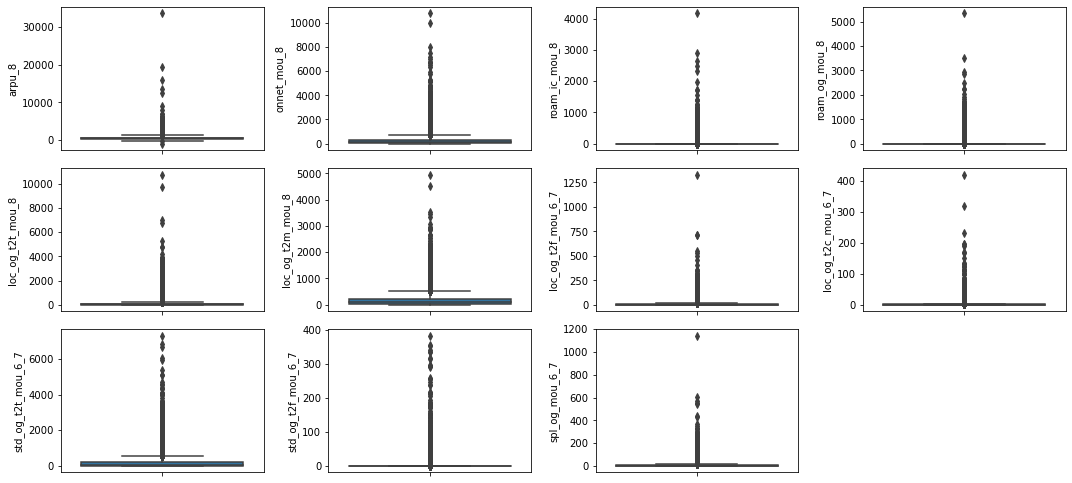

In [47]:
#Check the distribution of few numeric variables to check for outliers 
cols = ['arpu_8', 'onnet_mou_8','roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6_7', 'loc_og_t2c_mou_6_7',  'std_og_t2t_mou_6_7', 'std_og_t2f_mou_6_7', 'spl_og_mou_6_7']
plt.figure(figsize=(15,9))

#Drawing distribution of the identified continuous variables only to reduce number of charts
for i, col in enumerate(cols):
    plt.subplot(4,4,i+1)
    g = sns.boxplot(y=df_hvc[col].dropna())
    
plt.tight_layout()

#### Almost all numeric columns seem to have outliers in them except for aon. Let us cap them to .999 quantile 

In [48]:
#Columns to be capped
num_cols = list(df_hvc.select_dtypes(np.number).columns)

#Remove columns from this list that shouldn't be capped
num_cols.remove('Churn')

In [49]:
#Cap outliers to .999 quantile value.

for col in num_cols:
    col_999 = df_hvc[col].quantile(.999)
    df_hvc.loc[df_hvc[col] > col_999,col] = col_999

#### Check for outliers after capping

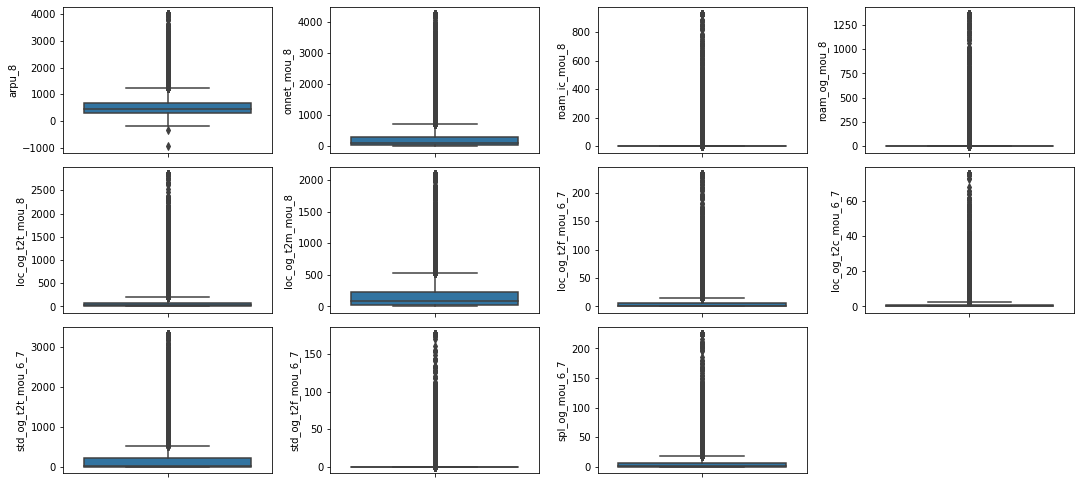

In [50]:
#Check the distribution of few numeric variables to check for outliers 
cols = ['arpu_8', 'onnet_mou_8','roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6_7', 'loc_og_t2c_mou_6_7',  'std_og_t2t_mou_6_7', 'std_og_t2f_mou_6_7', 'spl_og_mou_6_7']
plt.figure(figsize=(15,9))
#Drawing distribution of the identified continuous variables only to reduce number of charts
for i, col in enumerate(cols):
    plt.subplot(4,4,i+1)
    g = sns.boxplot(y=df_hvc[col])
    
plt.tight_layout()

#### Now there are no standing out liers, though there are outliers with more density. It is ok to leave them

## 6.2 Create Dummy Variables

In [51]:
#Create dummy variables for categorical variables
df_hvc = pd.get_dummies(df_hvc, drop_first=True)

In [52]:
#Check shape of dataframe after creation of dummy variable
df_hvc.shape

(30011, 85)

## 6.3 Train Test Split

In [53]:
#Independent Variables
X = df_hvc.drop(columns=['Churn'])

#Target Variables
y = df_hvc['Churn']

In [54]:
#Split data into train and test using 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#Check shapes after splitting
print(X_train.shape, X_test.shape)

(21007, 84) (9004, 84)


In [55]:
#Check Imbalance in train
y_train.value_counts(normalize=True)

0    0.913362
1    0.086638
Name: Churn, dtype: float64

In [56]:
#Check Imbalance in test
y_test.value_counts(normalize=True)

0    0.914149
1    0.085851
Name: Churn, dtype: float64

#### Imbalance in train and test is same, so data is stratified

## 6.4 Handle Imbalance

In [57]:
#Keep a copy of train and test
X_train_copy, y_train_copy = X_train.copy(), y_train.copy() 

In [58]:
#Use SMOTE to handle imnbalance in train data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train,y_train)

In [59]:
#Check shape after handling imbalance
print(X_train.shape, y_train.shape)

(38374, 84) (38374,)


In [60]:
#Check imbalance
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: Churn, dtype: float64

#### Data is now balanced

## 6.5 Scaling

In [61]:
#Check stats before scaling
X_train.describe()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_6_7,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,spl_og_mou_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,avg_rech_8,date_of_last_rech_6_NoRecharge,date_of_last_rech_6_Second,date_of_last_rech_7_NoRecharge,date_of_last_rech_7_Second,date_of_last_rech_8_NoRecharge,date_of_last_rech_8_Second,aon_500_1000,aon_1000_2000,aon_2000_3000,aon_gt_3000
count,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.00000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.00000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000
mean,392.017300,195.541728,268.696817,17.341572,30.210061,53.413312,103.505350,3.925796,1.269175,129.808046,136.588160,1.063255,4.824056,436.408984,41.131394,95.642415,8.918468,9.682117,19.815668,1.454414,186.428661,0.016204,7.163904,0.687723,7.972298,441.341517,122.166244,99.632387,90.078395,64.812494,41.858557,166.190178,0.066549,0.398848,0.110342,0.087136,83.189785,99.016610,94.47612,76.979232,589.453193,322.287749,434.856643,19.466578,36.340067,73.794504,142.867583,4.881062,1.627488,232.663279,256.268283,1.48070,6.598924,724.762742,56.340368,129.504383,11.509758,15.586479,29.513855,2.097381,257.756396,0.040390,10.030696,0.945483,12.432081,696.177009,162.041638,64.285014,209.700538,0.090689,0.466850,0.146833,0.127389,60.747117,0.001121,0.944155,0.003622,0.898838,0.026919,0.796425,0.179470,0.137489,0.093214,0.042086
std,407.541078,393.563879,412.162153,67.442313,103.410066,157.942088,187.800348,13.904396,4.859197,350.550575,344.653157,7.519411,14.825522,612.820929,110.993407,170.753137,31.245134,41.783304,70.554297,8.906961,296.399582,0.084769,44.765558,5.049625,8.176091,487.129858,152.942876,128.708233,125.936948,113.078909,184.648891,625.595475,0.268221,1.366439,0.449994,0.656931,301.305490,333.652405,317.33717,67.806663,337.943132,443.753030,470.391765,68.166630,112.430207,178.254270,197.194118,14.250588,4.471716,412.346703,442.623396,8.09560,13.784350,631.939155,124.440250,181.655526,33.496957,48.351760,76.049355,10.500910,310.572754,0.086234,47.427023,5.179159,8.265423,393.562780,143.744436,212

In [62]:
#Numeric Continuous columns to be scaled
cont_cols  = list(X_train.select_dtypes(['float64']).columns)
len(cont_cols)

74

In [63]:
# Instantiate scaler
scaler = MinMaxScaler()

# Fit and transform continuous numeric columns using the scaler on train data
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])

In [64]:
#Check stats after scaling
X_train.describe()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_6_7,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,spl_og_mou_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,avg_rech_8,date_of_last_rech_6_NoRecharge,date_of_last_rech_6_Second,date_of_last_rech_7_NoRecharge,date_of_last_rech_7_Second,date_of_last_rech_8_NoRecharge,date_of_last_rech_8_Second,aon_500_1000,aon_1000_2000,aon_2000_3000,aon_gt_3000
count,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000,38374.000000
mean,0.269450,0.045975,0.060080,0.018679,0.022131,0.018724,0.049303,0.016387,0.015576,0.034351,0.032214,0.006251,0.016297,0.075741,0.019784,0.043907,0.016704,0.010528,0.013729,0.007104,0.052785,0.016880,0.007250,0.005419,0.106297,0.087903,0.071905,0.064072,0.060997,0.059028,0.014839,0.018169,0.033274,0.022158,0.018390,0.006228,0.022109,0.023856,0.022113,0.070810,0.246478,0.080577,0.107213,0.023276,0.030997,0.026041,0.066896,0.020962,0.021621,0.070075,0.068807,0.008371,0.029425,0.137708,0.026903,0.061966,0.021391,0.017858,0.024701,0.009411,0.083899,0.058540,0.011288,0.007487,0.162352,0.083757,0.098995,0.023500,0.026153,0.045345,0.027462,0.026697,0.010616,0.060747,0.001121,0.944155,0.003622,0.898838,0.026919,0.796425,0.179470,0.137489,0.093214,0.042086
std,0.082082,0.092534,0.092158,0.072646,0.075755,0.055367,0.089456,0.058041,0.059633,0.092766,0.081285,0.044207,0.050085,0.106359,0.053387,0.078389,0.058520,0.045434,0.048881,0.043507,0.083922,0.088301,0.045304,0.039790,0.109015,0.097023,0.090019,0.082771,0.085279,0.102986,0.065459,0.068394,0.134110,0.075913,0.074999,0.046957,0.080077,0.080386,0.074277,0.068187,0.080002,0.110946,0.115974,0.081505,0.095901,0.062904,0.092333,0.061200,0.059406,0.124193,0.118843,0.045765,0.061465,0.120071,0.059421,0.086919,0.062254,0.055398,0.063647,0.047120,0.101090,0.124986,0.053371,0.041012,0.112462,0.100598,0.092981,0.077545,0.078650,0.135152,0.082371,0.082262,0.057731,0.080177,0.033456,0.229625,0.060077,0.301547,0.161850,0.402662,0.383751,0.344367,0.290736,0.200788
min

In [65]:
#Check test data stats before scaling
X_test.describe()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_6_7,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,spl_og_mou_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,avg_rech_8,date_of_last_rech_6_NoRecharge,date_of_last_rech_6_Second,date_of_last_rech_7_NoRecharge,date_of_last_rech_7_Second,date_of_last_rech_8_NoRecharge,date_of_last_rech_8_Second,aon_500_1000,aon_1000_2000,aon_2000_3000,aon_gt_3000
count,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.00000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000
mean,531.753280,273.011590,373.616568,12.753521,21.317739,87.123620,169.419029,6.465039,1.702915,175.354379,175.153553,1.813904,6.947775,628.429687,66.91242,154.430087,14.426835,14.355077,29.633680,2.480703,299.185783,0.027527,12.126027,1.076801,10.317748,610.607251,161.600733,103.369169,103.260671,94.031653,68.137793,256.341262,0.112839,0.613394,0.161817,0.141921,122.710009,130.039363,119.171160,78.649476,583.146096,303.117482,420.151644,15.927853,25.906339,96.781148,180.853467,7.032986,1.636362,194.652494,206.158346,2.135024,6.610692,699.773978,70.047902,160.304089,15.815499,16.217488,32.072064,2.739848,312.973864,0.040476,11.667921,1.192309,12.046141,690.587785,173.090604,76.061499,258.266252,0.127221,0.550977,0.168481,0.138383,81.227719,0.002110,0.959907,0.003776,0.968014,0.019547,0.930586,0.251666,0.227454,0.159485,0.079742
std,404.024964,461.404892,447.846262,62.234614,100.064441,210.275678,227.847212,18.065318,6.064397,402.973539,387.701559,10.417988,19.589577,670.150401,145.23781,206.448828,38.129829,53.832477,87.403979,12.112057,360.799761,0.110346,65.701615,6.496666,9.356135,497.245020,159.849369,135.964136,128.565547,127.519341,247.143228,763.907767,0.349442,1.781189,0.541844,0.890839,350.961528,379.835413,372.106648,70.175087,320.393063,430.585781,430.640883,62.898671,93.914666,225.225736,225.430037,18.511922,5.027987,371.698807,386.074891,11.339304,15.375930,603.610190,138.467206,198.113499,39.708533,55.251077,83.761186,12.620324,335.333476,0.092714,57.088739,6.179366,8.565382,376.772988,149.946220,234.560635,714.567977,0.333780,1.626044,0.505761,0.733558,89.637969,0.04

In [66]:
#Scale test data - Only transform scale data
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

In [67]:
#Check test data stats after scaling
X_test.describe()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_6_7,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,spl_og_mou_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,avg_rech_8,date_of_last_rech_6_NoRecharge,date_of_last_rech_6_Second,date_of_last_rech_7_NoRecharge,date_of_last_rech_7_Second,date_of_last_rech_8_NoRecharge,date_of_last_rech_8_Second,aon_500_1000,aon_1000_2000,aon_2000_3000,aon_gt_3000
count,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.00000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000,9004.000000
mean,0.297594,0.064190,0.083539,0.013737,0.015617,0.030542,0.080700,0.026987,0.020899,0.046404,0.041309,0.010664,0.023472,0.109068,0.032185,0.070895,0.027020,0.015609,0.020531,0.012117,0.084711,0.028674,0.012272,0.008485,0.137570,0.121616,0.095115,0.066475,0.069924,0.085639,0.024155,0.028025,0.056419,0.034077,0.026969,0.010144,0.032612,0.031330,0.027894,0.072490,0.244985,0.075784,0.103588,0.019045,0.022098,0.034153,0.084682,0.030204,0.021739,0.058627,0.055353,0.012070,0.029477,0.132960,0.033448,0.076703,0.029393,0.018581,0.026842,0.012294,0.101872,0.058665,0.013130,0.009441,0.157101,0.082328,0.106142,0.027805,0.032210,0.063611,0.03241,0.030633,0.011532,0.081228,0.002110,0.959907,0.003776,0.968014,0.019547,0.930586,0.251666,0.227454,0.159485,0.079742
std,0.081374,0.108485,0.100137,0.067036,0.073304,0.073713,0.108531,0.075410,0.074423,0.106638,0.091438,0.061248,0.066180,0.116308,0.069859,0.094776,0.071414,0.058536,0.060555,0.059162,0.102156,0.114944,0.066492,0.051193,0.124748,0.099037,0.094084,0.087437,0.087059,0.116138,0.087614,0.083515,0.174721,0.098955,0.090307,0.063677,0.093274,0.091513,0.087097,0.070568,0.075848,0.107654,0.106174,0.075207,0.080108,0.079480,0.105554,0.079501,0.066797,0.111950,0.103660,0.064102,0.068562,0.114688,0.066119,0.094794,0.073798,0.063302,0.070101,0.056630,0.109150,0.134378,0.064243,0.048932,0.116544,0.096306,0.096993,0.085746,0.089117,0.166890,0.09565,0.091957,0.061130,0.089638,0.045891,0.196189,0.061337,0.175972,0.138445,0.254170,0.433994,0.419212,0.366148,0.270909
min,0.150624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

# 7. Modeling

## 7.1 Interpretable Model - Logistic Regression

### Select features using RFE

In [68]:
%%time
#Instantiate logistic regression model
lr = LogisticRegression()

#Fit RFE to select 20 columns
rfe = RFE(lr, 20)

#Fit RFE with train data
rfe = rfe.fit(X_train, y_train)

Wall time: 23.6 s


In [69]:
#Columns selected by RFE
sel_cols = X_train.columns[rfe.support_]

#Print the columns selected by RFE
sel_cols

Index(['roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'total_og_mou_8', 'loc_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'total_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'arpu_6_7', 'loc_ic_t2m_mou_6_7',
       'total_ic_mou_6_7', 'total_rech_amt_6_7', 'aon_gt_3000'],
      dtype='object')

### Logistic Regression using Statsmodels

In [70]:
#Function to build a logistic regression model using statsmodel api
#Takes input data frame, target variable and list of columns to be selected from input dataframe as input
def build_model(X_, y_, columns = None):
    #Add Constant 
    if columns == None :
        X_sm = sm.add_constant(X_)
    else:
        X_sm = sm.add_constant(X_[columns])

    #Instantiate model
    lr_ = sm.GLM(y_, X_sm, family=sm.families.Binomial())

    #Fit Model
    model = lr_.fit()

    #Print Summary
    print(model.summary())
    return X_sm, model

In [71]:
#Function to predict values using the mode;
#Takes the model, input variables with constant, actual taget and cutoff as input
def make_pred(model, X_sm, actual, cutoff ):
    #Predict values
    pred = model.predict(X_sm)
    pred = pred.values.reshape(-1)
    
    #Create a data frame with Churn, Probability, Lead Number and Predicted Churn variables
    df_pred = pd.DataFrame({'Churn': actual.values, 'Churn_Prob':pred})
    df_pred['MobileNumber'] = actual.index
    
    #Predict using probability and cutoff
    df_pred['Churn_Pred'] = df_pred['Churn_Prob'].map(lambda x: 1 if x > cutoff else 0)
        
    return df_pred

In [72]:
#Function to calculate most commonly used metrics and print them
#Takes the predicted dataframe and only_acc as input. If only_acc is true, prints only accuracy
def calc_metrics(df_pred, only_acc = False):

    #Create confusion matrix using actual and prediocted values
    cm = confusion_matrix(df_pred.Churn, df_pred.Churn_Pred)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives

    #Calculate Sensitivity
    sens = TP / float(TP+FN)
    
    #Calculate Specificity
    spec = TN / float(TN+FP)
    
    #Calculate accuracy
    acc = accuracy_score(df_pred.Churn, df_pred.Churn_Pred)
    
    #Calculate precision
    prec = precision_score(df_pred.Churn, df_pred.Churn_Pred)
    
    #Calculate recall
    recall = recall_score(df_pred.Churn, df_pred.Churn_Pred)
    
    #Print metrics
    print(' Accuracy :', acc)
    if(only_acc == False):
           print(' Sensitivity:', sens, 
          '\n Specificity:', spec, '\n Precison:', prec, '\n Recall:', recall)
 

In [73]:
#Function to calculate most commonly used metrics and print them
#Takes the predicted dataframe, cutoff, is_pca and only_acc as input. 
#If only_acc is true, prints only accuracy. Default cutoff is 0.5. If is_pca is true, uses pca data
def calc_metrics_cutoff(model_, cutoff=0.5, is_pca=False, only_acc = False):

    if is_pca == True:
        pred_proba_ = model_.predict_proba(X_test_pca)
    else:
        pred_proba_ = model_.predict_proba(X_test)
    pred_ = pd.Series(pred_proba_[:,1]).map(lambda x: 0 if x < cutoff else 1)
    
    #Create confusion matrix using actual and prediocted values
    cm = confusion_matrix(y_test, pred_)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives

    #Calculate Sensitivity
    sens = TP / float(TP+FN)
    
    #Calculate Specificity
    spec = TN / float(TN+FP)
    
    #Calculate accuracy
    acc = accuracy_score(y_test, pred_)
    
    #Calculate precision
    prec = precision_score(y_test, pred_)
    
    #Calculate recall
    recall = recall_score(y_test, pred_)
    
    #Print metrics
    print('Scores with cutoff:', cutoff)
    print(' Accuracy :', acc)
    if(only_acc == False):
           print(' Sensitivity:', sens, 
          '\n Specificity:', spec, '\n Precison:', prec, '\n Recall:', recall)
 

In [74]:
#Function to calculate VIFs
#Takes the independent variable data frame and list of columns to be considered as input
def calc_vif(df_, columns):
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    
    #Features
    vif['Features'] = df_[columns].columns
    
    #Calculate Variance Inflation factor and round it to 2 decimals
    vif['VIF'] = [variance_inflation_factor(df_[columns].values, i) for i in range(df_[columns].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    
    #Sort valyes
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### Model 1

In [75]:
#With all columns selected by RFE
sel_cols = list(sel_cols)
X_train_sm,res = build_model(X_train, y_train, sel_cols)
print()
print(calc_vif(X_train, sel_cols)[:5])

#Predict values using 0.5 as cuoff
y_train_pred = make_pred(res, X_train_sm, y_train, 0.5)

print()
#Calculate and print metrics using these predictions
calc_metrics(y_train_pred, only_acc = True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                38374
Model:                            GLM   Df Residuals:                    38353
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15167.
Date:                Mon, 12 Oct 2020   Deviance:                       30334.
Time:                        19:43:00   Pearson chi2:                 4.46e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7041      0

#### All variables are significant. total_ic_mou_6_7 has high VIF. Drop it

### Model 2

In [76]:
sel_cols2 = sel_cols.copy()

#Remove total_ic_mou_6_7 column from this list as it has high vif
sel_cols2.remove('total_ic_mou_6_7')


#Model 2 - with all columns selected by RFE except total_ic_mou_6_7
#Build model and print summary
X_train_sm2, res2 = build_model(X_train, y_train, sel_cols2)

#Print VIFs
print(calc_vif(X_train, sel_cols2)[:5])

#Predict values using 0.5 as cuoff
y_train_pred2 = make_pred(res2, X_train_sm2, y_train, 0.5)

print()

#Calculate and print metrics using these predictions
calc_metrics(y_train_pred2, only_acc = True) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                38374
Model:                            GLM   Df Residuals:                    38354
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15207.
Date:                Mon, 12 Oct 2020   Deviance:                       30414.
Time:                        19:43:01   Pearson chi2:                 5.88e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6610      0

#### All variables are significant. loc_ic_t2m_mou_8 has high VIF. Drop it

### Model 3

In [77]:
sel_cols3 = sel_cols2.copy()

#Remove PageViews column from this list which has high VIF
sel_cols3.remove('loc_ic_t2m_mou_8')


#Model 3 - with all columns selected by RFE except Origin_Lead Add Form and PageViews
#Build model and print summary
X_train_sm3, res3 = build_model(X_train, y_train, sel_cols3)

print()
#Print VIFs
print(calc_vif(X_train, sel_cols3)[:5])

#Predict values using 0.5 as cuoff
y_train_pred3 = make_pred(res3, X_train_sm3, y_train, 0.5)

print()
#Calculate and print metrics using these predictions
calc_metrics(y_train_pred3, only_acc = True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                38374
Model:                            GLM   Df Residuals:                    38355
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15291.
Date:                Mon, 12 Oct 2020   Deviance:                       30583.
Time:                        19:43:01   Pearson chi2:                 3.95e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6241      0

#### All variables are significant and not multicollinear. There is one variable with VIF of 6.1.Let us keep it as it is not very high. Accuracy is down a bit, that is fine as we do not want our model to be overfit.

### Evaluate Models

#### ROC AUC Curve

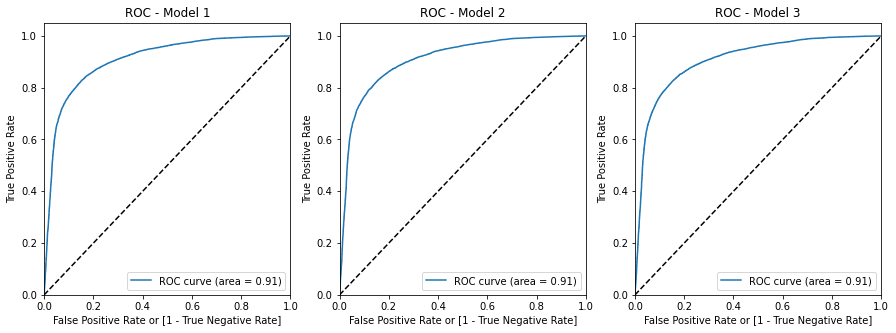

In [78]:
#List of data frames with train data predictions from all models
df_preds = [y_train_pred, y_train_pred2, y_train_pred3]

plt.figure(figsize=(15,5))

i=1

#Iterate through each train data predictions
for df_pre in df_preds:
    plt.subplot(1,3,i)
    actual = df_pre.Churn
    probs = df_pre.Churn_Prob
    
    #Calculate metrics
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    
    #Plot ROC
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Model '+ str(i))
    plt.legend(loc="lower right")
    i+=1


In [79]:
#Print all 3 model's metrics for train data with 0.5 cutoff
for i, df_pre in enumerate(df_preds):
    print('Model ' + str(i+1) + ' metrics for train data:')
    calc_metrics(df_pre)
    print()

Model 1 metrics for train data:
 Accuracy : 0.8332985875853443
 Sensitivity: 0.8558398915932662 
 Specificity: 0.8107572835774222 
 Precison: 0.8189208059046479 
 Recall: 0.8558398915932662

Model 2 metrics for train data:
 Accuracy : 0.8323604523896388
 Sensitivity: 0.8550581122635118 
 Specificity: 0.8096627925157659 
 Precison: 0.8179280087745537 
 Recall: 0.8550581122635118

Model 3 metrics for train data:
 Accuracy : 0.8320216813467451
 Sensitivity: 0.8556835357273154 
 Specificity: 0.808359826966175 
 Precison: 0.8170191589947748 
 Recall: 0.8556835357273154



#### All model's performance on train data is almost equal . Select Model 3 as our final Logistic Regression Model as it has only significant variables and no multi collinear variables in it.

### Find Optimal Cutoff

In [80]:
# Let's create columns with different probability cutoffs with 0.1 interval
numbers = [float(x)/10 for x in range(10)]

#Make predictions for each cutoff
for i in numbers:
    y_train_pred3[i]= y_train_pred3.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred3.head()

,Churn,Churn_Prob,MobileNumber,Churn_Pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.202388,0,0,1,1,1,0,0,0,0,0,0,0
1,0,0.107310,1,0,1,1,0,0,0,0,0,0,0,0
2,0,0.125461,2,0,1,1,0,0,0,0,0,0,0,0
3,0,0.176202,3,0,1,1,0,0,0,0,0,0,0,0
4,0,0.006865,4,0,1,0,0,0,0,0,0,0,0,0


In [81]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# Indicate what each value represent in confusion matrix to reduce confusion
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

#Probabilities at 0.1 interval to calculate scores
num = [float(x)/10 for x in range(10)]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred3.Churn, y_train_pred3[i] )
    total1=sum(sum(cm1))
    
    #Calculate accuracy, sensitivity and specificity
    accuracy = (cm1[0,0]+cm1[1,1])/total1    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    #Store scores in the main data frame
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    
#Print scores for each cutoff
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.699119  0.971543  0.426695
0.2   0.2  0.753818  0.948559  0.559076
0.3   0.3  0.789727  0.924636  0.654818
0.4   0.4  0.815682  0.894303  0.737062
0.5   0.5  0.832022  0.855684  0.808360
0.6   0.6  0.835592  0.802158  0.869026
0.7   0.7  0.827331  0.740137  0.914525
0.8   0.8  0.797832  0.645385  0.950279
0.9   0.9  0.598999  0.210820  0.987179


<Figure size 864x288 with 0 Axes>

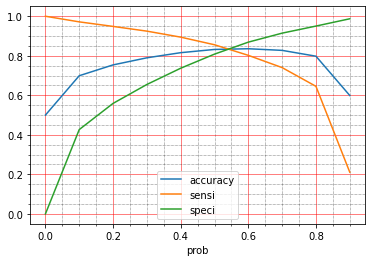

In [82]:
plt.figure(figsize=(12,4))
# Plot accuracy sensitivity and specificity for various probabilities.
fig, ax = plt.subplots()
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], ax=ax)
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### Optimal cutoff is at 0.55. As out goal is to good sensitivity, we may have to reduce the cutoff to get a better sensitivity.

### Precision and Recall Tradeoff

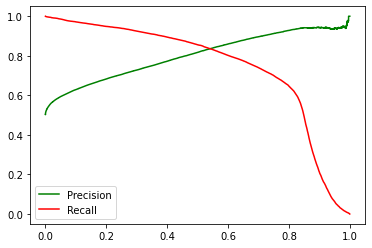

In [83]:
#Plot precision vs recall for model 3 
p, r, thresholds = precision_recall_curve(y_train_pred3.Churn, y_train_pred3.Churn_Prob)
p1, = plt.plot(thresholds, p[:-1], "g-")
p2, = plt.plot(thresholds, r[:-1], "r-")
plt.legend([p1,p2],['Precision','Recall'])
plt.show()

#### Precision and Recall is also optimal and balanced at 0.55 cutoff. As we want to maximize recall, as we can see from graph we may have to reduce the cutoff to get good recall score

### Predict Values for Test Data

#### Make predictions on test data using Model 3

In [84]:
#Add constant to test data input
X_test_sm = sm.add_constant(X_test[sel_cols3])

#<Make predictions using Model 3
df_test_pred = make_pred(res3, X_test_sm, y_test, 0.55)

#Calculate Scores and pritn them
calc_metrics(df_test_pred)

 Accuracy : 0.8358507330075522
 Sensitivity: 0.7736093143596378 
 Specificity: 0.8416960272141902 
 Precison: 0.3145712782745923 
 Recall: 0.7736093143596378


In [85]:
#Add constant to test data input
X_test_sm = sm.add_constant(X_test[sel_cols3])

#<Make predictions using Model 3
df_test_pred = make_pred(res3, X_test_sm, y_test, 0.4)

#Calculate Scores and pritn them
calc_metrics(df_test_pred)

 Accuracy : 0.7493336294980009
 Sensitivity: 0.8499353169469599 
 Specificity: 0.7398857975944599 
 Precison: 0.23481057898498928 
 Recall: 0.8499353169469599


#### Optimal cutoff of 0.55 has a lesser recall compared to 0.4. Hence, we use cutoff of 0.4 for our predictions as we want to maximize recall. This is to correctly identify all customers that may Churn even if some of the not Churn customers are predicted wrongly as Churn customers. Business doesn't want to loose customers.

### Model Summary

In [86]:
#Print Final Model's Summary. Final model is 3rd model
summary = res3.summary()

#First row in data is for headings
cols = summary.tables[1].data[0]

#Convert Summary to a dataframe to sort it on coefficients for easy interpretation 
summary_df = pd.DataFrame(summary.tables[1].data, columns=cols).drop(0)

#Convert coef to numberic for meaningful sorting
summary_df['coef'] = pd.to_numeric(summary_df['coef'])

In [87]:
#Print variables and coefficients in descending order
summary_df.sort_values(by='coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
16,arpu_6_7,5.8140,0.925,6.288,0.000,4.002,7.626
17,loc_ic_t2m_mou_6_7,3.6979,0.313,11.805,0.000,3.084,4.312
2,roam_og_mou_8,2.5130,0.218,11.526,0.000,2.086,2.940
18,total_rech_amt_6_7,1.5428,0.737,2.094,0.036,0.099,2.987
1,const,0.6241,0.168,3.724,0.000,0.296,0.952
3,loc_og_t2t_mou_8,-2.5796,0.499,-5.173,0.000,-3.557,-1.602
19,aon_gt_3000,-2.5976,0.138,-18.856,0.000,-2.868,-2.328
11,vol_2g_mb_8,-2.9075,0.381,-7.633,0.000,-3.654,-2.161
13,monthly_2g_8,-3.0492,0.186,-16.384,0.000,-3.414,-2.684
12,vol_3g_mb_8,-3.0595,0.447,-6.840,0.000,-3.936,-2.183



#### Features indicating that customer's will not churn : As the value in these columns go high, most likely customers will not churn 
total_ic_mou_8, loc_og_t2m_mou8, last_day_rch_amt_8, spl_ic_mou_8, monthly_3g_8

#### Features indicating that customers will churn : As the value in these columns go high, most likely customers will churn
arpu_6_7, loc_ic_t2m_mou_6_7, roam_og_mou_8, total_rch_amt_6_7, loc_og_t2t_mou_8


## 7.2 Random Forest

In [88]:
#Function to fit model and print appropriate metrics based on specified scoring
def fit_model(model, scoring = None):
    model.fit(X_train, y_train)
    if scoring == None:
        print('Train Score:', model.score(X_train,y_train))
        print('Test Score:', model.score(X_test,y_test))
    elif scoring=='roc_auc':
        print('Train ROC AUC Score:', roc_auc_score(y_train,model.predict_proba(X_train)[:,1] ) )
        print('Test ROC AUC Score:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1] ))
    elif scoring=='accuracy':
        print('Train Accuracy Score:', roc_auc_score(y_train,model.predict(X_train) ) )
        print('Test Accuracy Score:', accuracy_score(y_test, model.predict(X_test) ))

In [89]:
#Function to fit Grid Search CV and return results
def run_gcv(model, model_params):
    gscv = GridSearchCV(estimator=model, param_grid=model_params, n_jobs= -1, cv = cv,
                          return_train_score=True, verbose=1, scoring=scoring)
    gscv.fit(X_train,y_train)
    return gscv

In [90]:
#Function to plot params and their results from grid search cv. Assumes only two types of paramas are used
def plot_param_scores(param_grid, cv_results):
    param_li = list(param_grid.keys())
    param_values_li = list(param_grid.values())

    # # plotting
    plt.figure(figsize=(16,6))


    for n, subsample in enumerate(param_values_li[0]):


        # subplot 1/n
        plt.subplot(1,len(param_values_li[0]), n+1)
        df = cv_results[cv_results['param_'+param_li[0]]==subsample]

        x = df['param_'+param_li[1]]
        y1 = round(df["mean_test_score"], 3)
        y2 = round(df["mean_train_score"], 3)
        plt.plot(x, y1)
        plt.plot(x, y2)
        plt.xlabel(param_li[1])
        plt.ylabel('Score')
        plt.title("{0}={1}".format(param_li[0], subsample))
        plt.ylim([0.40, 1])
        plt.legend(['test score', 'train score'], loc='lower left')
        for a,b in zip(x,y1):
            plt.text(a,b,str(b))
        for a,b in zip(x,y2):
            plt.text(a,b,str(b))

In [91]:
#Global values for cv and scoring
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'accuracy'

In [92]:
#Instantiate Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
calc_metrics_cutoff(rf)

Scores with cutoff: 0.5
 Accuracy : 0.9314749000444247
 Sensitivity: 0.6895213454075032 
 Specificity: 0.9541975458632 
 Precison: 0.5857142857142857 
 Recall: 0.6895213454075032


#### Accuracy is good, however recall is low. Let us try to tune using hyper parameters

### Hyper Parameter Tuning

### Iteration 1

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.1min finished


Best Params: {'max_depth': 15, 'max_features': 11}


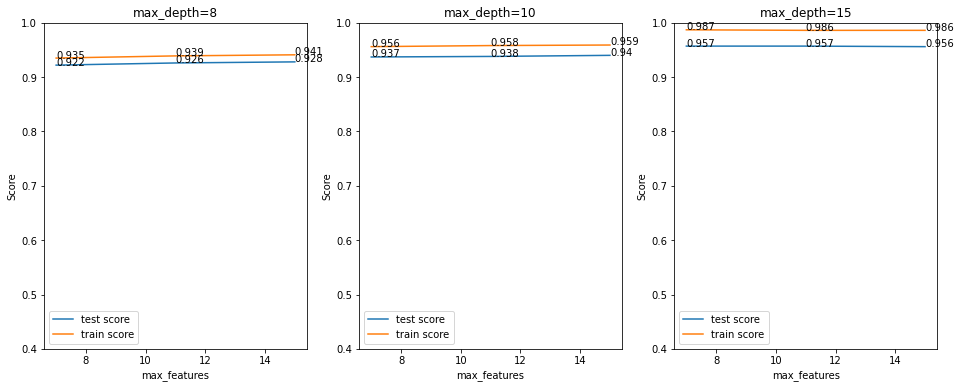

In [94]:
# Random Forest without any params
rfc_tune = RandomForestClassifier(oob_score=True)

#Start with tuning max_depth and max_features
rfc_params = {
    'max_depth' : [8, 10, 15],
    'max_features' : [7, 11, 15]
    }

rfc_gcv = run_gcv(rfc_tune, rfc_params)
plot_param_scores(rfc_params,pd.DataFrame(rfc_gcv.cv_results_))
print('Best Params:', rfc_gcv.best_params_)

#### With Max depth of 8 the gap between train and test scores is less, so 8 is optimal max depth though the score is slightly less.  Though the gap is same based on number of features, let us choose a lesser number of features to make the model generalizable

### Iteration 2

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


Best Params: {'min_samples_leaf': 10, 'n_estimators': 100}


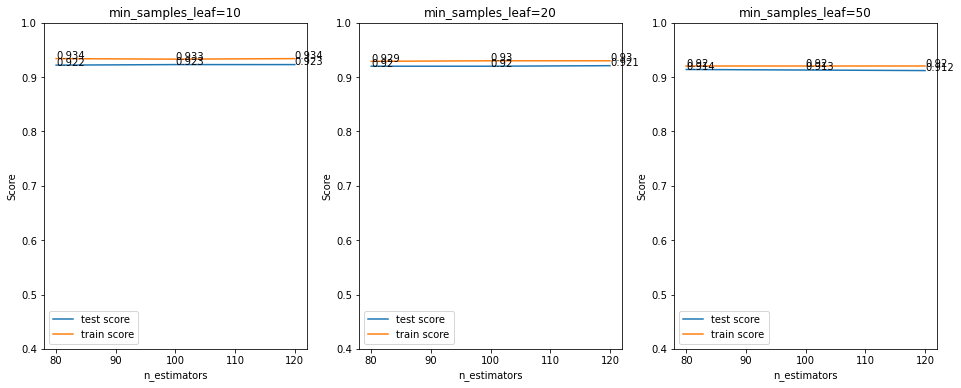

In [95]:
#Random Forest with previously identified params
rfc_tune = RandomForestClassifier(oob_score=True, max_depth=8, max_features=10)

#Try tuning min_samples_leaf and n_estimators
rfc_params = {
    'min_samples_leaf': [10, 20, 50],
    'n_estimators': [80, 100, 120]
    }

rfc_gcv = run_gcv(rfc_tune, rfc_params)
plot_param_scores(rfc_params,pd.DataFrame(rfc_gcv.cv_results_))
print('Best Params:', rfc_gcv.best_params_)

#### Scores are similar across the range of values choosen. To make the model more balanced, choose min_samples_leaf as 50

### Random Forest - Final Model

In [96]:
#Final model with optimal paramters
rfc_final = RandomForestClassifier(oob_score=True, max_depth=8, max_features=10, min_samples_leaf=50, n_estimators=80)
fit_model(rfc_final,'accuracy')

Train Accuracy Score: 0.9207275759628916
Test Accuracy Score: 0.9029320302087961


#### Accuracy of the model is good, even the gap between train and test is also low 

In [97]:
rfc_final = RandomForestClassifier(oob_score=True, max_depth=8, max_features=10, min_samples_leaf=50, n_estimators=80)
fit_model(rfc_final,'roc_auc')

Train ROC AUC Score: 0.9720764982285902
Test ROC AUC Score: 0.9181263902612831


#### Area Under Curve is good as well

In [98]:
#Calculate Scores with a cutoff of 0.5
calc_metrics_cutoff(rfc_final, 0.5)

Scores with cutoff: 0.5
 Accuracy : 0.9030430919591292
 Sensitivity: 0.7800776196636481 
 Specificity: 0.9145911796865508 
 Precison: 0.46171516079632463 
 Recall: 0.7800776196636481


In [99]:
#Calculate Scores with a cutoff of 0.3
calc_metrics_cutoff(rfc_final, 0.3)

Scores with cutoff: 0.3
 Accuracy : 0.820191026210573
 Sensitivity: 0.8641655886157826 
 Specificity: 0.8160612319280768 
 Precison: 0.30614115490375804 
 Recall: 0.8641655886157826


#### Scores have improved with a lesser cutoff. Since, the business objective is to identify all customers who may churn, the focus should be on ensuring that False Negatives should be as less as possible or a higher recall value is expected. To achieve this low probability cutoff can be chosen to boost recall. As the recall is impressive this could be our final model to be used. Let us check with PCA as well. 

## 6.3 Modeling with PCA

In [100]:
#Instantiate and fit PCA
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(random_state=42)

### Scree Plot

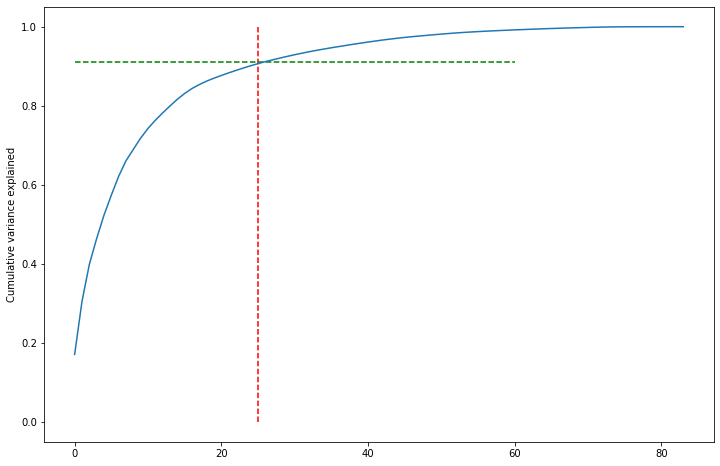

In [101]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.vlines(x=25, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.91, xmax=60, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

#### Use 25 components which gives us more than 90% of variance

In [102]:
#PCA with 25 components
pca_final = PCA(n_components=25)

#Fit and transform on train data 
X_train_pca = pca_final.fit_transform(X_train)
print(X_train_pca.shape)

#Transform test data 
X_test_pca = pca_final.transform(X_test)
print(X_test_pca.shape)

(38374, 25)
(9004, 25)


### 6.3.1 Logistic Regression with PCA

In [103]:
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca, y_train)

In [104]:
calc_metrics_cutoff(model_pca, is_pca=True)

Scores with cutoff: 0.5
 Accuracy : 0.8359617947578853
 Sensitivity: 0.6597671410090556 
 Specificity: 0.8525088081642571 
 Precison: 0.29582366589327147 
 Recall: 0.6597671410090556


#### Logistic Regression performed well without PCA in terms of sensititvity or recall. Hence we can ignore this model.

### 6.3.2 XGBoost

In [105]:
#Instantiate base XG Boost classifier
xgclf = xgb.XGBClassifier()

#Fit the model
xgclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgclf.predict_proba(X_train)[:, 1]))
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgclf.predict_proba(X_test)[:, 1]))

AUC on train data by XGBoost = 0.9999020157954764
AUC on test data by XGBoost = 0.9151876374347884


In [107]:
calc_metrics_cutoff(xgclf)

Scores with cutoff: 0.5
 Accuracy : 0.932252332296757
 Sensitivity: 0.5847347994825356 
 Specificity: 0.9648888348924797 
 Precison: 0.6099865047233468 
 Recall: 0.5847347994825356


In [108]:
calc_metrics_cutoff(xgclf, cutoff=0.3)

Scores with cutoff: 0.3
 Accuracy : 0.9256996890270991
 Sensitivity: 0.6946959896507116 
 Specificity: 0.9473939982991131 
 Precison: 0.5536082474226804 
 Recall: 0.6946959896507116


#### XGBoost performed better in terms of accuracy. However, recall score with cuutoff of 0.5 is low. Since, the business objective is to identify all customers who may churn, the focus should be on ensuring that False Negatives should be as less as possible or a higher recall value is expected. To achieve this low probability cutoff can be chosen to boost recall.

### 6.3.3 XGBoost with PCA

In [109]:
xgclf = xgb.XGBClassifier()

xgclf.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [110]:
print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgclf.predict_proba(X_train_pca)[:, 1]))
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgclf.predict_proba(X_test_pca)[:, 1]))

AUC on train data by XGBoost = 0.9966080371239531
AUC on test data by XGBoost = 0.8589258762545848


In [111]:
#Calculate metrics on test data
calc_metrics_cutoff(xgclf, is_pca=True)

Scores with cutoff: 0.5
 Accuracy : 0.8880497556641492
 Sensitivity: 0.5808538163001293 
 Specificity: 0.9168995261815089 
 Precison: 0.39629302736098854 
 Recall: 0.5808538163001293


#### This is a overfit model as test score is very less compared to train. Hence, the recall score is also too low on test data. XGBoost with PCA variables doesn't perform well. Company would end up losing customers by using this model. Let us try to tune hyper parameters

### Hyper Parameter Tuning for XGBoost with PCA

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Best Params: {'learning_rate': 0.3, 'max_depth': 10}


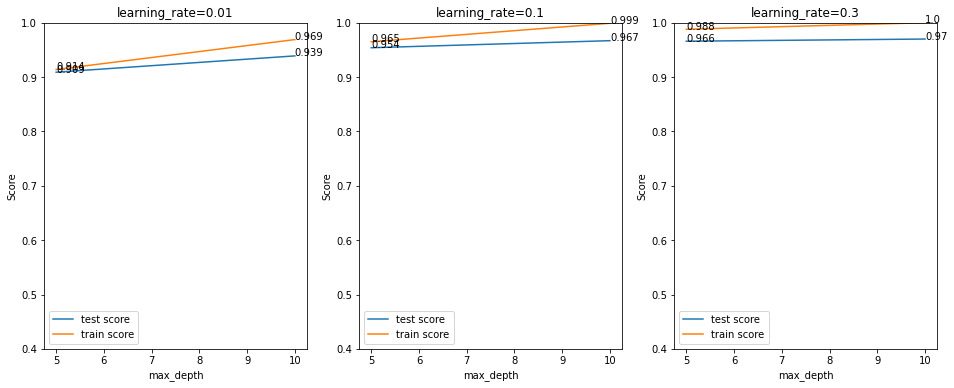

In [112]:
#Default model without any params
xgb_tune = xgb.XGBClassifier()

#Tune learning_rate amd max_depth
xgb_params = {'learning_rate': [0.01, 0.1, 0.3],
              'max_depth': [ 5, 10 ]
             }

#Run GridSearchCv with these params
xgb_gcv = run_gcv(xgb_tune, xgb_params)
plot_param_scores(xgb_params,pd.DataFrame(xgb_gcv.cv_results_))
print('Best Params:', xgb_gcv.best_params_)

#### It is evident from the graphs that learning rate of 0.1 and max_depth of 0.5 gives us a balanced model with good score and less train/test gap.

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Best Params: {'min_child_weight': 5, 'n_estimators': 100}


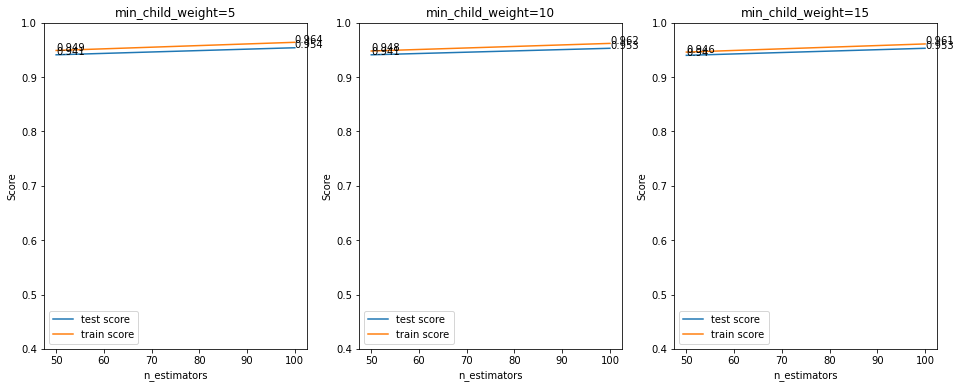

In [113]:
#Model with previously identified optimal params
xgb_tune = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5)

#Tuning on min_child_weight and n_estimators
xgb_params = {'min_child_weight': [5, 10, 15],
              'n_estimators': [50, 100]
             }

#Run GridSearchCv with these params
xgb_gcv = run_gcv(xgb_tune, xgb_params)
plot_param_scores(xgb_params,pd.DataFrame(xgb_gcv.cv_results_))
print('Best Params:', xgb_gcv.best_params_)

#### Gap between train/test is same across. Choosing a min_child_weight of 15 to make the model more generalized

In [114]:
#Final XG boost model with optimal parameters
xgb_final = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, min_child_weight = 15, n_estimators = 100)

xgb_final.fit(X_train_pca, y_train)

print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgb_final.predict_proba(X_train_pca)[:, 1]))
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgb_final.predict_proba(X_test_pca)[:, 1]))

print('Train Accuracy:', accuracy_score(y_train, xgb_final.predict(X_train_pca)))
print('Test Accuracy:', accuracy_score(y_test, xgb_final.predict(X_test_pca)))

AUC on train data by XGBoost = 0.9678591952638664
AUC on test data by XGBoost = 0.8585133066658831
Train Accuracy: 0.9066555480273102
Test Accuracy: 0.8708351843625055


In [115]:
# Calculate metrics on test data
calc_metrics_cutoff(xgb_final, is_pca=True)

Scores with cutoff: 0.5
 Accuracy : 0.8708351843625055
 Sensitivity: 0.6494178525226391 
 Specificity: 0.8916292066577572 
 Precison: 0.3601147776183644 
 Recall: 0.6494178525226391


In [116]:
# Calculate metrics on test data
calc_metrics_cutoff(xgb_final, is_pca=True, cutoff=0.3)

Scores with cutoff: 0.3
 Accuracy : 0.8055308751665926
 Sensitivity: 0.7567917205692108 
 Specificity: 0.8101081278095007 
 Precison: 0.2723463687150838 
 Recall: 0.7567917205692108


#### XGBoost model with PCA is good with respect to accuracy.  As we can see, Recall is low with cutoff of 0.5 and it is improving with lower cutoff. Hence, this model can be used with a lower cutoff. However recall is lower than Random Forest, so we can prefer Random Forest over this model.

## 6.4 Decision Tree

In [117]:
#Decision Tree with random set of params
dt = DecisionTreeClassifier(max_depth = 10, random_state=100, max_leaf_nodes=20, max_features=50, min_samples_leaf=20,
                           min_samples_split=50)
#Fit Model
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features=50, max_leaf_nodes=20,
                       min_samples_leaf=20, min_samples_split=50,
                       random_state=100)

In [118]:
# Calculate metrics on test data
calc_metrics_cutoff(dt)

Scores with cutoff: 0.5
 Accuracy : 0.8650599733451799
 Sensitivity: 0.7839586028460543 
 Specificity: 0.8726764670149435 
 Precison: 0.36638452237001207 
 Recall: 0.7839586028460543


#### Our base model with Decision tree performed well on both accuracy and recall. Let us try to tune it

### Hyper Parameter Tuning

#### Iteration 1:

In [119]:
# Create the parameter grid based on the results of random search to tune it
params = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [8, 10, 15, 20]
}

In [120]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [121]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    9.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.7s finished


Wall time: 10.1 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, max_features=50,
                                              max_leaf_nodes=20,
                                              min_samples_leaf=20,
                                              min_samples_split=50,
                                              random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': [8, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [122]:
dt_mod1 = grid_search.best_estimator_

In [123]:
#Calculate Metrics on test data
calc_metrics_cutoff(dt_mod1, 0.5 )

Scores with cutoff: 0.5
 Accuracy : 0.8643936028431808
 Sensitivity: 0.7658473479948253 
 Specificity: 0.8736484023812416 
 Precison: 0.3627450980392157 
 Recall: 0.7658473479948253


In [124]:
#Calculate Metrics on test data with a cutoff of 0.4
calc_metrics_cutoff(dt_mod1, 0.4 )

Scores with cutoff: 0.4
 Accuracy : 0.8406263882718792
 Sensitivity: 0.7917205692108668 
 Specificity: 0.845219292917021 
 Precison: 0.3244962884411453 
 Recall: 0.7917205692108668


####  There is a slight improvement compared to base model. Try tuning further around previous best params

In [125]:
dt_mod1

DecisionTreeClassifier(max_depth=10, max_features=15, max_leaf_nodes=20,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

#### Iteration 2:

In [126]:
# Updating the parameters based on Iteration 1 results
params = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [40, 50, 60],
    'max_features': [13, 15, 17]
}

In [127]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [128]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    5.0s finished


Wall time: 5.56 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, max_features=50,
                                              max_leaf_nodes=20,
                                              min_samples_leaf=20,
                                              min_samples_split=50,
                                              random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12], 'max_features': [13, 15, 17],
                         'min_samples_leaf': [40, 50, 60]},
             scoring='accuracy', verbose=1)

In [129]:
dt_mod2 = grid_search.best_estimator_
dt_mod2

DecisionTreeClassifier(max_depth=8, max_features=17, max_leaf_nodes=20,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

In [130]:
#Calculate Metrics on test data
calc_metrics_cutoff(dt_mod1, 0.5 )

Scores with cutoff: 0.5
 Accuracy : 0.8643936028431808
 Sensitivity: 0.7658473479948253 
 Specificity: 0.8736484023812416 
 Precison: 0.3627450980392157 
 Recall: 0.7658473479948253


In [131]:
#Calculate Metrics on test data
calc_metrics_cutoff(dt_mod1, 0.4 )

Scores with cutoff: 0.4
 Accuracy : 0.8406263882718792
 Sensitivity: 0.7917205692108668 
 Specificity: 0.845219292917021 
 Precison: 0.3244962884411453 
 Recall: 0.7917205692108668


#### This model is as good as iteration 1, choose a model with less complexity as our final model

In [132]:
#Final Decision Tree Model with optimal parameters
dt_final = DecisionTreeClassifier(max_depth=8, max_features=15,min_samples_leaf=50, random_state=42)
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_features=15, min_samples_leaf=50,
                       random_state=42)

In [133]:
#Calculate Metrics on test data
calc_metrics_cutoff(dt_final, 0.5 )

Scores with cutoff: 0.5
 Accuracy : 0.8633940470901822
 Sensitivity: 0.759379042690815 
 Specificity: 0.8731624346980926 
 Precison: 0.35990190067443284 
 Recall: 0.759379042690815


In [134]:
#Calculate Metrics on test data
calc_metrics_cutoff(dt_final, 0.4 )

Scores with cutoff: 0.4
 Accuracy : 0.8505108840515326
 Sensitivity: 0.7943078913324709 
 Specificity: 0.8557890900255133 
 Precison: 0.34092171016102163 
 Recall: 0.7943078913324709


#### Decision Tree has good accuracy as well as recall. However Random Forest performed better than this with respect to recall. So, Random Forest is preferred over this. 

## 7. Visualization of Churn against important features

#### Results of Logistic Regression Model:
#### Features indicating that customer's will not churn :
total_ic_mou_8, loc_og_t2m_mou8, last_day_rch_amt_8, spl_ic_mou_8, monthly_3g_8

#### Features indicating that customers will churn :
arpu_6_7, loc_ic_t2m_mou_6_7, roam_og_mou_8, total_rch_amt_6_7, loc_og_t2t_mou_8


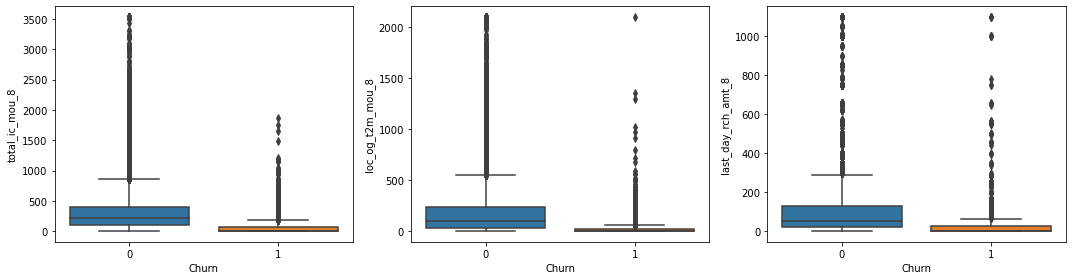

In [135]:
not_churn_cols=['total_ic_mou_8','loc_og_t2m_mou_8','last_day_rch_amt_8']
plt.figure(figsize=(15,4))

for i, col in enumerate(not_churn_cols):
    plt.subplot(1,3,i+1)
    sns.boxplot(x='Churn', y=col, data=df_hvc)
    
plt.tight_layout()

#### These are box plots for columns that indicates customers will not churn. These columns have a higher median for customers who didn't churn as expected

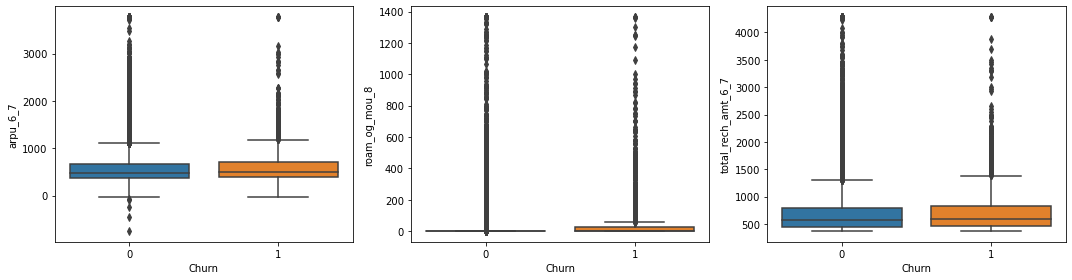

In [136]:
churn_cols=['arpu_6_7','roam_og_mou_8', 'total_rech_amt_6_7']
plt.figure(figsize=(15,4))

for i, col in enumerate(churn_cols):
    plt.subplot(1,3,i+1)
    sns.boxplot(x='Churn', y=col, data=df_hvc)
    
plt.tight_layout()

#### These are box plots for columns that indicates customers will churn. These columns have a higher median for customers who churn

## 8. Final Recommendations and Suggestions

#### Accurate and Sensitive Model:
Random Forest has outperformed all other models with highest recall values and still preserving the accuracy. So, Business can use this model to identify the customers who may churn soon and retain them by offering discounts or additional voice/data buckets.

#### Interpretable Model:
Logistic Regression model has proven to be effective in identifying the features responsible for churn as it keeps both accuracy and recall values high.

Following are the best parameters to achieve the business objective of reducing the churn for the company:

#### Top 5 Variables indicating that customer will not churn:
1. total_ic_mou_8: customers with higher incoming voice minutes in August are more likely to stay with the company
2. loc_og_t2m_mou8: higher number of outgoing off-net voice calls in August indicates that the customer will not churn soon
3. last_day_rch_amt_8: Customers who recharged on last day of August do not churn
4. spl_ic_mou_8: Customers receiving special incoming calls in August did not get churned
5. monthly_3g_8: Customers who opted for monthly 3G plans were not churned

#### Top 5 Variables indicating that customer will churn:
1. arpu_6_7: Customers for whom Average Revenue value in June and July was high were churned
2. loc_ic_t2m_mou_6_7: Subscribers who received more incoming calls from other operators in June and July, got churned
3. roam_og_mou_8: Customers who made more outgoing calls while roaming in August, got churned
4. total_rch_amt_6_7: Customers who recharged more in June and July switched their service provider
5. loc_og_t2t_mou_8: More local outgoing local calls within the network in August was an indicator that customer may get churned

#### Suggestions for the company to retain their customers:
1. Fact that subscribers who received more calls from other operators in June/July got churned indicates that people on other network are making more calls. This might be due to other operator providing low call rates/discounts. Business should investigate and provide similar benefits as competitor
2. Outgoing roaming calls caused the customer to churn - roaming charges should be reviewed. Other operators might be providing offers/additional benefits to roaming customers. Moreover, customers who are more often out of the circle (roaming), should be identified and should be provided with offers and discounts from time to time.
3. On last day of the month Business should launch surprise campaigns to provide additonal benefits to customers who recharge on that day. This is because the customers recharging on last day of month tend to stay longer
4. Company should review and enhance its portfolio for 3G monthly plans as customers opting for it do not get churned




